In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load cleaned data
df = pd.read_csv('../data/cleaned_Retail_data.csv', parse_dates=['Order Date'])

# Date features
df['Year']  = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Weekday'] = df['Order Date'].dt.weekday

# Define X and y
features = ['Discount','Profit','Year','Month','Weekday',
            'Category','Sub Category','Region','City']
X = df[features]
y = df['Sales']

# One‑hot encode categorical features
cat_feats = ['Category','Sub Category','Region','City']
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_feats)
], remainder='passthrough')

X_enc = preprocessor.fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42
)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest':     RandomForestRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"{name} RMSE: {rmse:.2f}")

LinearRegression RMSE: 463.77
RandomForest RMSE: 476.46


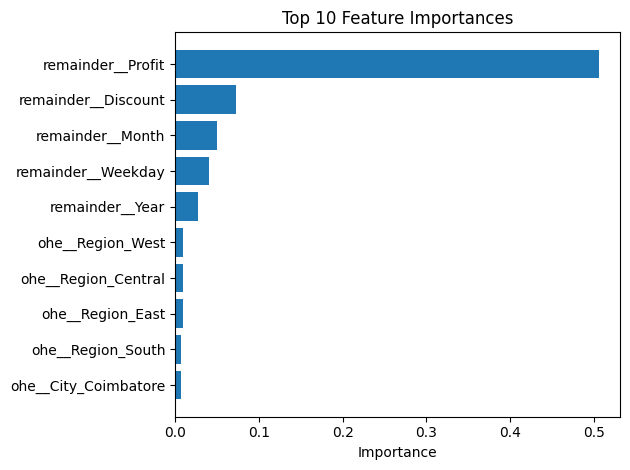

In [21]:
import matplotlib.pyplot as plt

rf = models['RandomForest']
importances = rf.feature_importances_
feat_names = preprocessor.get_feature_names_out()
indices = np.argsort(importances)[-10:]  
# top 10

plt.barh(feat_names[indices], importances[indices])
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [6]:
from prophet import Prophet

# Aggregate daily sales
ts = df.groupby('Order Date')['Sales'] \
       .sum() \
       .reset_index() \
       .rename(columns={'Order Date':'ds','Sales':'y'})

14:41:09 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing


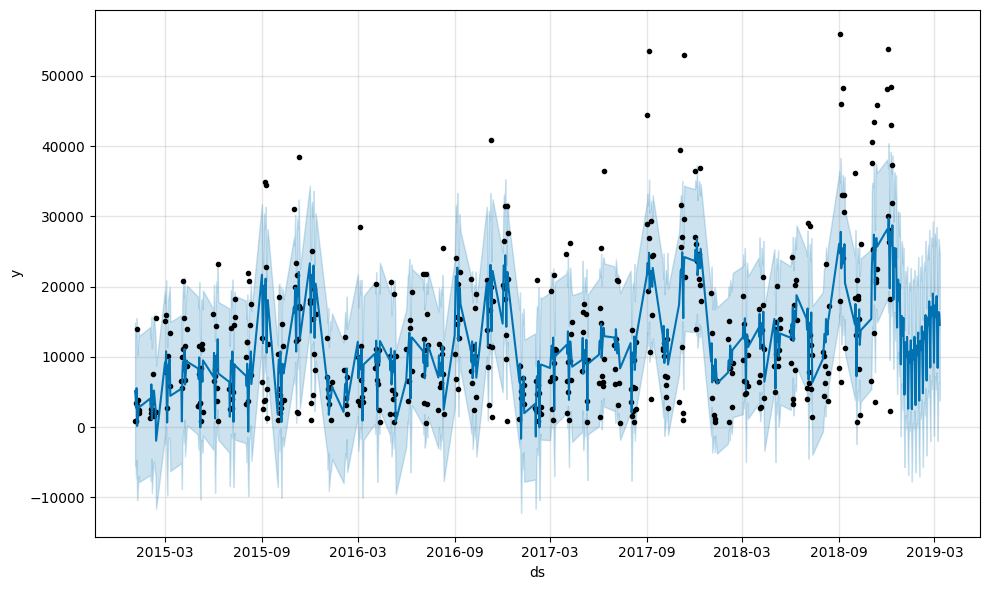

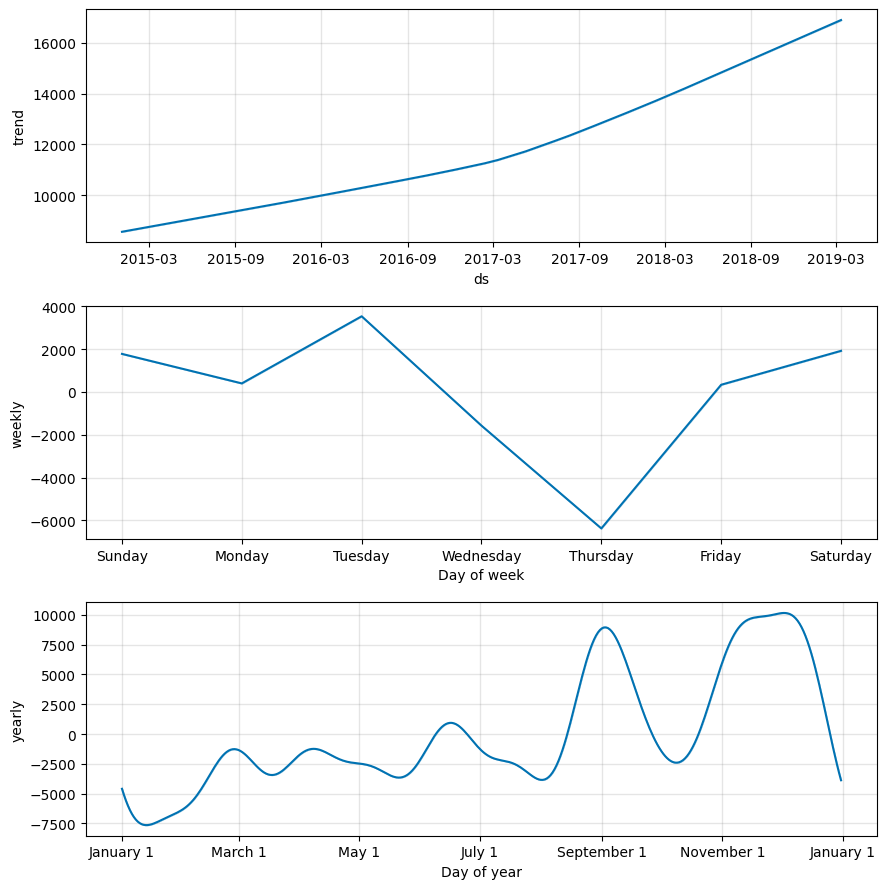

In [7]:
# Fit model
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(ts)

# Create future dataframe for next 90 days
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

# Plot
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [8]:
# summary.xlsx
with pd.ExcelWriter('E:/supermart‑analytics/reports/summary.xlsx') as writer:
    df.describe().to_excel(writer, sheet_name='Stats')
    df.groupby('Category')['Sales'].sum().to_excel(writer, sheet_name='SalesByCategory')


In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from pathlib import Path


# Create charts directory
charts_dir = Path("reports/charts")
charts_dir.mkdir(parents=True, exist_ok=True)

# Chart A: Daily Sales Trend
ts = df.groupby('Order Date')['Sales'].sum().reset_index()
plt.figure()
plt.plot(ts['Order Date'], ts['Sales'])
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
trend_path = charts_dir / 'sales_trend.png'
plt.savefig(trend_path)
plt.close()

#Chart B: Sales by Category
cat_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
plt.figure()
plt.bar(cat_sales.index, cat_sales.values)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
bycat_path = charts_dir / 'sales_by_category.png'
plt.savefig(bycat_path)
plt.close()

# Build PDF with embedded charts
c = canvas.Canvas("reports/sales_report.pdf", pagesize=letter)
c.setFont("Helvetica-Bold", 20)
c.drawString(50, 750, "Supermart Sales Report")

c.setFont("Helvetica", 12)
c.drawString(50, 720, f"Total Orders: {len(df):,}")
c.drawString(50, 700, f"Total Sales : ₹{df['Sales'].sum():,.2f}")

# Embed Chart A
c.drawImage(str(trend_path), 50, 380, width=500, height=250)

# New page for Chart B
c.showPage()
c.setFont("Helvetica-Bold", 20)
c.drawString(50, 750, "Supermart Sales Report")

c.drawImage(str(bycat_path), 50, 380, width=500, height=300)

c.showPage()
c.save()